# Тематическое моделирвание

In [1]:
import artm
import copy
import pandas as pd
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Буду использовать TopicNet для удобной визуализации.

In [3]:
import topicnet
from topicnet.cooking_machine.models import TopicModel
from topicnet.viewers import TopTokensViewer
from topicnet.viewers import TopDocumentsViewer
from topicnet.cooking_machine.dataset import Dataset

In [4]:
def perplexity_plot(model):
    plt.plot(model.score_tracker['PerlexityScore'].value)
    plt.title('Dependence Perlexity of iteration')
    plt.xlabel('number of iteration')
    plt.ylabel('Perlexity Score')

def perplexity_plot_ngram(model):
    plt.plot(model.score_tracker['PerlexityScore_ngram'].value)
    plt.title('Dependence Perlexity of iteration')
    plt.xlabel('number of iteration')
    plt.ylabel('Perlexity Score')

def perplexity_plot_info(model):
    plt.plot(model.score_tracker['PerlexityScore_info'].value)
    plt.title('Dependence Perlexity of iteration')
    plt.xlabel('number of iteration')
    plt.ylabel('Perlexity Score')

## ARTM с двумя модальностями и регуляризаторами

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path='vw_documents_ngram_info.txt',
                                        data_format='vowpal_wabbit',
                                        batch_size = 10000,
                                        target_folder='./batches')

In [6]:
file = open('vw_documents_ngram_info.txt', 'r')
print('Всего документов: ', len(file.readlines()))
file.close()

Всего документов:  4955


In [7]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='./batches')

In [8]:
dictionary

artm.Dictionary(name=5d822e2d-1c09-4da3-b304-b1b4880af45c, num_entries=4032)

In [9]:
NUM_TOPICS = 15

model = artm.ARTM(num_topics=NUM_TOPICS,
                  num_processors=4,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  cache_theta = True,
                  dictionary=dictionary)

In [10]:
model.class_ids = {'@ngram': 5.0, '@info': 1.0}

In [11]:
model.scores.add(artm.PerplexityScore(name='PerlexityScore_ngram', class_ids=['@ngram']))
model.scores.add(artm.PerplexityScore(name='PerlexityScore_info', class_ids=['@info']))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_ngram', class_id='@ngram'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_info', class_id='@info'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, class_id='@ngram'))
model.scores.add(artm.TopicMassPhiScore(name='TopicMassPhiScore',
                                        class_ids=['@ngram'], model_name=model.model_nwt))

In [12]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

In [13]:
theta = model.get_theta()
phi = model.get_phi()
print('Размер теты: ', theta.shape)
print('Размер фи: ', phi.shape)

Размер теты:  (15, 4955)
Размер фи:  (4032, 15)


In [14]:
import collections
duplicates = [item for item, count in collections.Counter(theta.columns).items() if count > 1]
print(duplicates)

[]


In [15]:
duplicates_phi = [item for item, count in collections.Counter(phi.index).items() if count > 1]
print(duplicates_phi)

[]


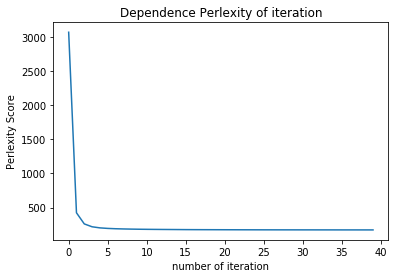

In [16]:
perplexity_plot_ngram(model)

In [17]:
artm_topic_model = TopicModel(model)
artm_topic_model.describe_scores()

last_value
model_id                   score_name                                 
--20h22m51s_13d06m2020y--- PerlexityScore_ngram                172.713
                           PerlexityScore_info                 42.0613
                           SparsityPhiScore_ngram             0.880177
                           SparsityPhiScore_info              0.169591
                           SparsityThetaScore                 0.107003
                           TopTokensScore.average_coherence          0
                           TopTokensScore.num_tokens               150
                           TopicMassPhiScore                         1

In [18]:
data = Dataset('preprocessed_data_for_TopicNet.csv')

In [19]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_ngram',
                                                       class_ids=['@ngram'],
                                                       dictionary=dictionary))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_info',
                                                       class_ids=['@info'],
                                                       dictionary=dictionary))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer'))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer_ngram',
                                                       class_ids=['@ngram']))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer_info',
                                                       class_ids=['@info']))

Посмотрим, при каких коэффициентах регуляризации перплексия меньше всего.

In [20]:
def coef_ref_search_artm(model):
    grid_SparsePhi_ngram = [-1, -10, -100, -1000]
    grid_SparsePhi_info = [-1]
    grid_SparseTheta = [-10]
    grid_DecorrelatorPhi_ngram = [10, 100, 1000, 10000]
    grid_DecorrelatorPhi_info = [1]
    grid_weight_ngram = [1, 5, 10]
    grid_weight_info = [1, 5, 10]
    scores = []
    reg_coefs = []
    i = 0

    for tau_SparsePhi_ngram in grid_SparsePhi_ngram:
        for tau_SparsePhi_info in grid_SparsePhi_info:
            for tau_SparseTheta in grid_SparseTheta:
                for tau_DecorrelatorPhi_ngram in grid_DecorrelatorPhi_ngram:
                    for tau_DecorrelatorPhi_info in grid_DecorrelatorPhi_info:
                        for weight_info in grid_weight_info:
                            for weight_ngram in grid_weight_ngram:
                                new_model = model.clone()
                                score = dict()
                                r_coefs = dict()

                                new_model.class_ids = {'@ngram': weight_ngram, '@info': weight_info}
                                new_model.regularizers['SparsePhiRegularizer_ngram'].tau = tau_SparsePhi_ngram
                                new_model.regularizers['SparsePhiRegularizer_info'].tau = tau_SparsePhi_info
                                new_model.regularizers['SparseThetaRegularizer'].tau = tau_SparseTheta
                                new_model.regularizers['DecorrelatorPhiRegularizer_ngram'].tau = tau_DecorrelatorPhi_ngram                
                                new_model.regularizers['DecorrelatorPhiRegularizer_info'].tau = tau_DecorrelatorPhi_info

                                new_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

                                topic_model = TopicModel(new_model)
                                print(i)
                                i += 1
                                print(topic_model.describe_scores())
                                print(topic_model.describe_regularizers())
                                score['PerlexityScore'] = new_model.score_tracker['PerlexityScore'].last_value
                                score['SparsityPhiScore_ngram'] = new_model.score_tracker['SparsityPhiScore_ngram'].last_value
                                score['SparsityPhiScore_info'] = new_model.score_tracker['SparsityPhiScore_info'].last_value
                                score['SparsityThetaScore'] = new_model.score_tracker['SparsityThetaScore'].last_value
                                scores.append(score)

                                r_coefs['SparsePhiRegularizer_ngram'] = tau_SparsePhi_ngram
                                r_coefs['SparsePhiRegularizer_info'] = tau_SparsePhi_info
                                r_coefs['SparseThetaRegularizer'] = tau_SparseTheta
                                r_coefs['DecorrelatorPhiRegularizer_ngram'] = tau_DecorrelatorPhi_ngram
                                r_coefs['DecorrelatorPhiRegularizer_info'] = tau_DecorrelatorPhi_info
                                r_coefs['weight_ngram'] = weight_ngram
                                r_coefs['weight_info'] = weight_info

                                reg_coefs.append(r_coefs)

                                #perplexity_plot(new_model)
                        
    return (scores, reg_coefs)

In [21]:
# %%time
# (scores, reg_coefs) = coef_ref_search_artm(model)

In [22]:
# num = 0
# min_perplexy = 4000
# index_min_perplexy = 0
# for i in range(len(scores)):
#     if (scores[i]['PerlexityScore'] < 5000.0) & \
#     (scores[i]['SparsityPhiScore_ngram'] > 0.7) & (scores[i]['SparsityPhiScore_ngram'] < 0.96) & \
#     (scores[i]['SparsityThetaScore'] < 0.971):
#         print(i, scores[i])
#         print('SparsePhiRegularizer_ngram', reg_coefs[i]['SparsePhiRegularizer_ngram'])
#         print('SparsePhiRegularizer_info', reg_coefs[i]['SparsePhiRegularizer_info'])
#         print('SparseThetaRegularizer', reg_coefs[i]['SparseThetaRegularizer'])
#         print('DecorrelatorPhiRegularizer_ngram', reg_coefs[i]['DecorrelatorPhiRegularizer_ngram'])
#         print('DecorrelatorPhiRegularizer_info', reg_coefs[i]['DecorrelatorPhiRegularizer_info'])
#         print()
#         num+=1
#         if scores[i]['PerlexityScore'] < min_perplexy:
#             min_perplexy = scores[i]['PerlexityScore']
#             index_min_perplexy = i
# print('Всего {} хороших моделей'.format(num))
# print('min_perplexy:', min_perplexy)
# print('index_min_perplexy:', index_min_perplexy)

Было 233

In [23]:
# reg_coefs[index_min_perplexy]

In [24]:
best_model = model.clone()
best_model.cache_theta=True

best_model.regularizers['SparsePhiRegularizer_ngram'].tau = -100
best_model.regularizers['SparsePhiRegularizer_info'].tau = -1
best_model.regularizers['SparseThetaRegularizer'].tau = -10
best_model.regularizers['DecorrelatorPhiRegularizer_ngram'].tau = 10
best_model.regularizers['DecorrelatorPhiRegularizer_info'].tau = 0.1

best_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

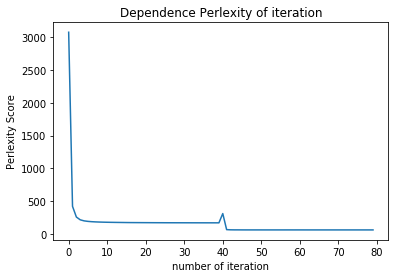

In [25]:
perplexity_plot_ngram(best_model)

In [26]:
best_model.score_tracker['TopicMassPhiScore'].last_topic_mass

{'topic_0': 6362.49169921875,
 'topic_1': 7572.3662109375,
 'topic_2': 6427.6533203125,
 'topic_3': 5557.68798828125,
 'topic_4': 6002.2216796875,
 'topic_5': 5364.662109375,
 'topic_6': 7184.74658203125,
 'topic_7': 6413.65625,
 'topic_8': 6064.677734375,
 'topic_9': 8494.8720703125,
 'topic_10': 5974.36669921875,
 'topic_11': 5762.3623046875,
 'topic_12': 6501.32275390625,
 'topic_13': 6732.63232421875,
 'topic_14': 5919.27880859375}

In [27]:
topic_model = TopicModel(best_model)

In [28]:
topic_model.describe_scores()

last_value
model_id                   score_name                                 
--20h23m07s_13d06m2020y--- PerlexityScore_ngram                65.0067
                           PerlexityScore_info                 28.9266
                           SparsityPhiScore_ngram             0.911077
                           SparsityPhiScore_info              0.225731
                           SparsityThetaScore                 0.947447
                           TopTokensScore.average_coherence          0
                           TopTokensScore.num_tokens               150
                           TopicMassPhiScore                         1

In [29]:
TopTokensViewer(model=topic_model).view_from_jupyter()

topic_0 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.918790 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.004830 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.768530 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.653620 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.755490 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.522690 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.228830 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.138370 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.012520 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 2.834780 
 
 topic_0 modality token 
 
 @ngram 
 управление 
 2.819000 
 
 
 научиться 
 1.936480 
 
 
 проектный 
 1.719900 
 
 
 освоение 
 1.526050 
 
 
 цифровой 
 1.483310 
 
 
 управлять 
 1.397880 
 
 
 образование 
 1.277030 
 
 
 компетенция 
 1.196380 
 
 
 профессия 
 1.075890 
 
 
 эффективный 
 0.985920

topic_1 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 9.081000 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.841500 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.516720 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.936790 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.766280 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.587710 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.319150 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.231620 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.673320 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.318340 
 
 topic_1 modality token 
 
 @ngram 
 стать 
 7.141790 
 
 
 специалист 
 3.888540 
 
 
 кругозор 
 3.552210 
 
 
 хороший 
 3.478260 
 
 
 диссертация 
 2.655060 
 
 
 стать_хороший 
 2.487540 
 
 
 расширение 
 2.381140 
 
 
 расширение_кругозор 
 2.152180 
 
 
 свой 
 1.781680 
 
 
 защитить 
 1.761440

topic_2 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 10.570650 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.507630 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 4.092310 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.964970 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.881470 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.711420 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.702820 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.418030 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.404330 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.259730 
 
 topic_2 modality token 
 
 @ngram 
 повышение 
 15.695430 
 
 
 профессиональный 
 7.832970 
 
 
 уровень 
 7.211460 
 
 
 повышение_уровень 
 4.294230 
 
 
 компетенция 
 4.085830 
 
 
 квалификация 
 3.535970 
 
 
 повышение_профессиональный 
 3.192910 
 
 
 повышение_квалификация 
 2.780940 
 
 
 профессиональный_уровень 
 2.007290 
 
 
 компетентность 
 1.750100

topic_3 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.738540 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.857980 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.856580 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.152070 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.622380 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.554480 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.476330 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.388110 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.380120 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.957370 
 
 topic_3 modality token 
 
 @ngram 
 новое 
 6.141750 
 
 
 узнать 
 5.332870 
 
 
 узнать_новое 
 4.043210 
 
 
 научиться 
 3.101160 
 
 
 вуз 
 1.703530 
 
 
 узнавать 
 1.329910 
 
 
 узнавать_новое 
 1.180450 
 
 
 большой 
 1.176420 
 
 
 закончить 
 1.100700 
 
 
 закончить_вуз 
 1.031210

topic_4 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.453700 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 5.522240 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.339710 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.124100 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.943800 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.685710 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.080010 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.064670 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.775280 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.707090 
 
 topic_4 modality token 
 
 @ngram 
 рынок 
 2.288630 
 
 
 время 
 2.218910 
 
 
 труд 
 1.880240 
 
 
 рынок_труд 
 1.812420 
 
 
 нога 
 1.676560 
 
 
 нога_время 
 1.405250 
 
 
 идти 
 1.269780 
 
 
 навык 
 1.244950 
 
 
 идти_нога 
 1.202190 
 
 
 получить 
 1.114360

topic_5 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.819800 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.464890 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.914680 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.984200 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.860970 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.648130 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.259340 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.136820 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.036810 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.601610 
 
 topic_5 modality token 
 
 @ngram 
 развитие 
 9.643330 
 
 
 новый 
 4.200880 
 
 
 компетенция 
 3.496340 
 
 
 профессиональный 
 2.862000 
 
 
 развитие_профессиональный 
 2.300820 
 
 
 сфера 
 2.122870 
 
 
 учёба 
 2.058760 
 
 
 навык 
 1.997940 
 
 
 закончить_учёба 
 1.180840 
 
 
 закончить 
 1.175400

topic_6 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 10.178760 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.976100 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 4.358140 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.883260 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.811320 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.748840 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.174320 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.137920 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.123990 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.023360 
 
 topic_6 modality token 
 
 @ngram 
 знание 
 12.149230 
 
 
 получение 
 9.301140 
 
 
 новый 
 9.225020 
 
 
 новый_знание 
 5.845780 
 
 
 получение_новый 
 5.784180 
 
 
 навык 
 3.849930 
 
 
 получение_знание 
 2.411330 
 
 
 приобретение 
 2.197710 
 
 
 приобретение_новый 
 2.164690 
 
 
 получить 
 1.894730

topic_7 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.136570 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.782550 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.699130 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.246420 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.801830 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.668610 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.409990 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.135100 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.446190 
 
 
 &ТИП_ЦЕЛИ_Включиться_в_новый_проект/деятельность 
 2.403010 
 
 topic_7 modality token 
 
 @ngram 
 стать 
 4.974540 
 
 
 свой 
 3.317700 
 
 
 курс 
 2.752270 
 
 
 область 
 2.554560 
 
 
 профессионал 
 2.170570 
 
 
 который 
 1.527160 
 
 
 стать_профессионал 
 1.526110 
 
 
 дело 
 1.525900 
 
 
 эксперт 
 1.461400 
 
 
 интересный 
 1.396520

topic_8 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.059900 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.448240 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.017520 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.276020 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.835610 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.460610 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.256170 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.204970 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.844820 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.653260 
 
 topic_8 modality token 
 
 @ngram 
 иностранный 
 2.845320 
 
 
 язык 
 2.832850 
 
 
 иностранный_язык 
 2.707140 
 
 
 цель 
 1.866460 
 
 
 задача 
 1.468630 
 
 
 достижение 
 1.407680 
 
 
 свой 
 1.301650 
 
 
 саморазвитие 
 1.263850 
 
 
 выучить 
 1.244940 
 
 
 успех 
 1.064430

topic_9 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 10.301710 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.782790 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 5.601140 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.714010 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.917020 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.684610 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.534280 
 
 
 &ОБЛАСТЬ_ЦЕЛИ_Иностранные_языки,_гуманитарные_знания_и_навыки 
 3.371160 
 
 
 &ПОДОБЛАСТЬ_ЦЕЛИ_Иностранные_языки 
 3.295490 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.248130 
 
 topic_9 modality token 
 
 @ngram 
 язык 
 9.193080 
 
 
 английский 
 7.140100 
 
 
 английский_язык 
 5.080770 
 
 
 выучить 
 4.373520 
 
 
 высокий 
 3.490000 
 
 
 образование 
 2.790010 
 
 
 высокий_образование 
 2.672990 
 
 
 получить 
 2.408790 
 
 
 получить_высокий 
 2.265180 
 
 
 выучить_английский 
 2.214260

topic_10 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.099940 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.483220 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.424500 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.962480 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.791710 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.214170 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.043100 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 2.962040 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.669710 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.568650 
 
 topic_10 modality token 
 
 @ngram 
 рост 
 4.045810 
 
 
 карьерный 
 3.998040 
 
 
 карьерный_рост 
 3.932120 
 
 
 работа 
 3.739860 
 
 
 получить 
 2.355080 
 
 
 который 
 1.499920 
 
 
 личный 
 1.337840 
 
 
 образование 
 1.242620 
 
 
 хотеть 
 1.221660 
 
 
 найти 
 1.016860

topic_11 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.465720 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.763010 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.962800 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.273190 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.038890 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.479670 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.193980 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.050910 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.670270 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.659710 
 
 topic_11 modality token 
 
 @ngram 
 проект 
 2.943990 
 
 
 личностный 
 2.893980 
 
 
 рост 
 2.124840 
 
 
 большой 
 1.821870 
 
 
 развитие 
 1.758560 
 
 
 личностный_рост 
 1.754110 
 
 
 знать 
 1.610870 
 
 
 создать 
 1.397600 
 
 
 мир 
 1.369650 
 
 
 читать 
 1.327980

topic_12 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 7.853410 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.514580 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.514780 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.939590 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.444990 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.392940 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.387280 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.099990 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.006130 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.802900 
 
 topic_12 modality token 
 
 @ngram 
 знание 
 9.108010 
 
 
 новое 
 7.961540 
 
 
 новое_знание 
 4.507780 
 
 
 получить 
 3.659320 
 
 
 получить_новое 
 2.991110 
 
 
 свой 
 1.498730 
 
 
 совершенствование 
 1.466590 
 
 
 навык 
 1.446030 
 
 
 углубление 
 1.418000 
 
 
 область 
 1.307850

topic_13 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.563490 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.786090 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.878470 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.945950 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.634110 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.451660 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.405000 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.937090 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.934870 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 2.646100 
 
 topic_13 modality token 
 
 @ngram 
 свой 
 7.070870 
 
 
 уровень 
 5.714860 
 
 
 повысить 
 5.636990 
 
 
 профессиональный 
 2.777570 
 
 
 знание 
 2.646640 
 
 
 повысить_уровень 
 2.573960 
 
 
 навык 
 2.185370 
 
 
 повысить_свой 
 2.003040 
 
 
 компетенция 
 1.562610 
 
 
 уровень_знание 
 1.497120

topic_14 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.830450 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.896500 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.578050 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.110660 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.987240 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.657520 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.650320 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.231190 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.029420 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.317680 
 
 topic_14 modality token 
 
 @ngram 
 знание 
 7.494580 
 
 
 умение 
 5.905420 
 
 
 навык 
 4.813860 
 
 
 знание_умение 
 4.233080 
 
 
 область 
 3.336610 
 
 
 умение_навык 
 2.856720 
 
 
 компетенция 
 2.518430 
 
 
 приобретение 
 2.165320 
 
 
 приобретение_знание 
 1.631440 
 
 
 необходимый 
 1.520840

In [30]:
TopDocumentsViewer(model=topic_model, dataset=data, max_top_number=10).view_from_jupyter()

Topic name: topic_0 5435 Не останавливаться на достигнутом и быть в движении. 3734 Освоение новых психологических практик. 2309 Развитие лидерских качеств. 2332 Научиться ставить и достигать целей. 3242 Узнать многое по проектной деятельности. 4568 Обеспечить свою готовность к любым изменениям, связанным с человеческим прогрессом в эпоху цифровой трансформации. 3716 Обладать широким кругозором в разных областях. 1859 Развить компетенции проектного менеджмента. 3224 Проектный менеджмент. 2300 Развитие навыков управления и проектной деятельности. Topic name: topic_1 3440 Расширить кругозор. 3420 грамотный управленец. 3555 Состояться как лидер и грамотный руководитель . 3536 Стать лучше. 3488 Расширить кругозор. 3481 Расширение кругозора. 3460 Расширение кругозора. 3619 Защитить докторскую диссертацию. 3353 Подготовка к защите докторской диссертации. 3341 Освоить знания в системе IT и искусственного интеллекта. Topic name: topic_2 3719 Повышение компетенций и навыков. 3623 Повышение профессиональных навыков . 3842 повышение уровня знаний. 3796 Карьерное развитие (повышение). 3765 Повышение компетенции. 3738 повышение профессионального уровня. 3913 развитие своих профессиональных компетенций. 3715 Самообразование для профессионального роста. 3538 повышение профессиональной компетенции и социальной значимости. 3572 повышение уровня знаний. Topic name: topic_3 3891 Узнать новые программы и как работать в них.Например, Python. 3868 свободно говорить на английском. 3960 Научиться просчитывать на перспективу эффекты и последствия в том числе с учетом неявных факторов. 3935 Узнать новое. 3908 Научиться летать на самолете. 4022 Научиться писать хорошие тексты. 3878 Научиться распределять время и расставлять приоритеты. 3808 Закончить ВУЗ. 3819 учиться, узнавать много нового. 4150 Понять, что будет развиваться в будущем, и начать учиться в данной области. Topic name: topic_4 3813 Прочитать свой список запланированных книг на квартал. 3888 Создать новую экосистему в Вузе пройдя которую, студент будет готов быть руководителем. . 3603 развить творческие способности. 3604 развить творческие способности. 3629 Зашита диссертации. 3637 Понять алгоритмы взаимодействия сущностей составляющих мою реальность). 3681 вывод стартапа на стабильную прибыльность. 3755 Идти в ногу со временем. 3762 Идти в ногу с запросами социума . 3568 Быть в курсе тенденций рынка труда. Topic name: topic_5 4049 Обучение новым технологиям. 4144 Стать высококвалифицированным специалистом . 3788 Digital skills. 3873 Изучение работающих методик обучения предпринимателей. 3905 развитие профессиональных качеств. 3955 Формирование новых форматов мышления. 4008 Расширить знания (шире и глубже) . 4011 Получить комплекс универсальных компетенций, наиболее востребованных сейчас. 4013 Обучение новым сферам в проектировании. 4047 глубже познакомиться с новыми идеями. Topic name: topic_6 3433 получение знания. 3345 Расширение теоретических знаний. 3595 интерес к новым знаниям. 3567 Своевременная актуализация профессиональных знаний и навыков. 3478 получение знаний. 3452 Получение новых знаний. 3651 формирование базы знаний. 3236 Получение новых знаний. 3269 Всегда быть в процессе обучения и реализации полученных знаний. 3657 Получение новейших компетенций . Topic name: topic_7 3958 Быть достойным специалистом в своей должности. 3956 Стать умнее, чем был вчера. 4045 Пройти обучение CDO. 4042 Разработать курс для предпринимателей, который поможет научиться вести управленческий учет с нуля. 4031 пройти курсы. 4140 Быть профессионалом в своей области. 3903 Найти интересный и нужный навык. 3939 быть профессионалом в своей отрасли. 4270 Пересдать единый гос.экзамен. 3942 Освоить методы машинного обучения. Topic name: topic_8 4197 Подготовка всех направлений в деятельности учреждения к сертификации Росздравнадзора. 4252 Изучение иностранных языков. 3807 Выучить несколько новых языков. 3884 разобраться в новых направлениях. 3885 Саморазвитие и самообразование через всю жизнь. 3910 изучить при

In [31]:
theta = best_model.get_theta()

In [32]:
phi = best_model.get_phi()

# Классификация!

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [34]:
from sklearn.metrics import roc_curve
import math
from scipy.spatial.distance import euclidean

In [35]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [36]:
from sklearn.linear_model import LogisticRegression

@ignore_warnings(category=ConvergenceWarning)
def expiriment(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                  'penalty': ['l1', 'l2'],
                  'solver': ['liblinear', 'saga']}
    optimizer = GridSearchCV(LogisticRegression(penalty='l2', C=1, class_weight='balanced'), param_grid, scoring="roc_auc", cv=3)
    optimizer.fit(X_train, y_train)
    
    y_pred_proba = optimizer.predict_proba(X_test)[:, 1]
    y_pred_labels = optimizer.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred_labels)
    recall = recall_score(y_test, y_pred_labels)
    accuracy = accuracy_score(y_test, y_pred_labels)
    
    print('roc_auc', roc_auc)
    print('precision', precision)
    print('recall', recall)
    print('accuracy', accuracy)
    print(optimizer.best_params_)
    return roc_auc, precision, recall, accuracy

In [37]:
dataset = pd.read_csv('preprocessed_data_for_specificity_prediction.csv')

## Векторизация с помощью тематического моделирования

In [38]:
theta = best_model.get_theta()
theta_transposed = theta.T

In [39]:
X_topic = pd.DataFrame(data=theta_transposed,
                       columns = theta_transposed.columns,
                       index = theta_transposed.index)

In [40]:
y_sp = dataset['specificity']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_topic, y_sp, test_size=0.3,
                                                    random_state=42, stratify=y_sp)

In [42]:
clf = LogisticRegression(penalty='l2', random_state=42, solver='liblinear').fit(X_train, y_train)
y_pred_labels = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [43]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
accuracy = accuracy_score(y_test, y_pred_labels)

In [44]:
print(roc_auc)
print(precision)
print(recall)
print(accuracy)

0.6595805206446773
0.5853269537480064
0.5518796992481203
0.624747814391392


## Векторизация с помощью классических эмбеддингов

In [173]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

In [276]:
X_text = dataset['goal']

In [282]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_text)

In [363]:
X_train_count_vect, X_test_count_vect, y_train_count_vect, y_test_count_vect = train_test_split(X, y_sp,
                                                                                                test_size=0.3,
                                                                                                stratify=y_sp)

Наивный байесовский классификатор с мультиномиальным распределением

In [364]:
mnb = MultinomialNB()
mnb.fit(X_train_count_vect.toarray(), y_train_count_vect)
y_pred_proba_mnb = mnb.predict_proba(X_test_count_vect.toarray())[:, 1]
y_pred_labels_mnb = mnb.predict(X_test_count_vect.toarray())

In [365]:
roc_auc = roc_auc_score(y_test_count_vect, y_pred_proba_mnb)
precision = precision_score(y_test_count_vect, y_pred_labels_mnb)
recall = recall_score(y_test_count_vect, y_pred_labels_mnb)
accuracy = accuracy_score(y_test_count_vect, y_pred_labels_mnb)

In [366]:
print(roc_auc)
print(precision)
print(recall)
print(accuracy)

0.8535938386111264
0.7888513513513513
0.7022556390977444
0.7827841291190316


In [367]:
baseline_results = pd.DataFrame(index=['roc_auc', 'precision', 'recall', 'accuracy'])

In [368]:
baseline_results['MultinomialNB'] = [roc_auc, precision, recall, accuracy]

Логистическая регрессия с CountVectorizer

In [369]:
clf = LogisticRegression(penalty='l1', random_state=42, solver='liblinear').fit(X_train_count_vect,
                                                                           y_train_count_vect)
y_pred_labels_count_vect = clf.predict(X_test_count_vect)
y_pred_proba_count_vect = clf.predict_proba(X_test_count_vect)[:, 1]

In [370]:
roc_auc = roc_auc_score(y_test_count_vect, y_pred_proba_count_vect)
precision = precision_score(y_test_count_vect, y_pred_labels_count_vect)
recall = recall_score(y_test_count_vect, y_pred_labels_count_vect)
accuracy = accuracy_score(y_test_count_vect, y_pred_labels_count_vect)

In [371]:
print(roc_auc)
print(precision)
print(recall)
print(accuracy)

0.8537786071016958
0.7923211169284468
0.6827067669172933
0.7780766644250168


In [372]:
baseline_results['LogRegression_CV'] = [roc_auc, precision, recall, accuracy]

In [194]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

In [195]:
X_train_Tfidf, X_test_Tfidf, y_train_Tfidf, y_test_Tfidf = train_test_split(X, y_sp, test_size=0.3,
                                                                        random_state=42, stratify=y_sp)

Логистическая регрессия с Tfidf

In [199]:
clf = LogisticRegression(penalty='l1', random_state=42, solver='saga').fit(X_train_Tfidf, y_train_Tfidf)
y_pred_labels_Tfidf = clf.predict(X_test_Tfidf)
y_pred_proba_Tfidf = clf.predict_proba(X_test_Tfidf)[:, 1]

In [200]:
roc_auc = roc_auc_score(y_test_Tfidf, y_pred_proba_Tfidf)
precision = precision_score(y_test_Tfidf, y_pred_labels_Tfidf)
recall = recall_score(y_test_Tfidf, y_pred_labels_Tfidf)
accuracy = accuracy_score(y_test_Tfidf, y_pred_labels_Tfidf)

In [201]:
print(roc_auc)
print(precision)
print(recall)
print(accuracy)

0.8578197318112801
0.7981308411214953
0.6421052631578947
0.7673167451244116


In [67]:
baseline_results['LogRegression_Tfidf'] = [roc_auc, precision, recall, accuracy]

In [68]:
baseline_results

,MultinomialNB,LogRegression_CV,LogRegression_Tfidf
roc_auc,0.870377,0.863713,0.857820
precision,0.814503,0.813433,0.798131
recall,0.726316,0.655639,0.642105
accuracy,0.803631,0.778749,0.767317


In [392]:
file = open('./tables/baseline_results.txt', 'w')
file.write(baseline_results.to_latex())
file.close()

Хотим избежать ошибок FalsePositive, поэтому будем смотреть на метрики presicion и recall. В качестве бейзлайна выберем модель, которая дала наилучший резулат относительно presicion. Это логистическая регрессия, где векторизация документов проводилась с помощью CountVectorizer.

Также можно попробовать Fasttext и классификацию с помощью artm, она точно должна работать лучше, чем то, что сделала я.

## ARTM classification с двумя модальностями и регуляризаторами

In [202]:
dataset = pd.read_csv('preprocessed_data_for_specificity_prediction.csv')
dataset.index=dataset['id']

In [203]:
dataset.isnull().values.any()

False

In [204]:
X_train, X_test, y_train, y_test = train_test_split(dataset['vw_ngram_info_labels'], dataset['specificity'],
                                                    test_size=0.3, random_state=42,
                                                    stratify=dataset['specificity'])

X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

In [205]:
vw_file_train = open('vw_documents_train.txt', 'w')
vw_file_test = open('vw_documents_test.txt', 'w')

for index, goal in dataset.iterrows():
    if index in X_train.index:
        vw_file_train.write(goal['vw_ngram_info_labels']+'\n')
    else:
        vw_file_test.write(goal['vw_ngram_info']+'\n')
        
vw_file_train.close()
vw_file_test.close()

In [206]:
train_batch_vectorizer=artm.BatchVectorizer(data_path='vw_documents_train.txt',
                                            data_format='vowpal_wabbit',
                                            batch_size=10000,
                                            target_folder='./train_batches')
dictionary = train_batch_vectorizer.dictionary

### Подбираю параметры

In [207]:
def coef_ref_search_specifisity(train_batch_vectorizer):
    grid_SparsePhi_ngram = [-10, -100, -1000]
    grid_SparsePhi_info = [-1]
    grid_SparsePhi_specificity = [-10]
    grid_SparseTheta = [-10]
    grid_DecorrelatorPhi_ngram = [100, 1000, 10000]
    grid_DecorrelatorPhi_info = [1]
    grid_weight_ngram = [1, 5, 10]
    grid_weight_info = [1, 5, 10]
    grid_weight_specificity = [1, 5, 10, 20]
    grid_num_topics = [15]
    scores = []
    reg_coefs = []
    i = 0
    
    for tau_SparsePhi_ngram in grid_SparsePhi_ngram:
        for tau_SparsePhi_info in grid_SparsePhi_info:
            for tau_SparsePhi_specificity in grid_SparsePhi_specificity:
                    for tau_SparseTheta in grid_SparseTheta:
                        for tau_DecorrelatorPhi_ngram in grid_DecorrelatorPhi_ngram:
                            for tau_DecorrelatorPhi_info in grid_DecorrelatorPhi_info:
                                for weight_info in grid_weight_info:
                                    for weight_ngram in grid_weight_ngram:
                                        for weight_specifisity in grid_weight_specificity:
                                            for numer_topics in grid_num_topics:
                                                print(i)
                                                i += 1

                                                new_model = artm.ARTM(num_topics=numer_topics,
                                                                      num_processors=7,
                                                                      cache_theta=True,
                                                                      theta_columns_naming='title',
                                                                      show_progress_bars=True,
                                                                      dictionary=train_batch_vectorizer.dictionary)

                                                new_model.class_ids = {'@ngram': weight_ngram,
                                                                       '@info': weight_info,
                                                                       '@specificity':weight_specifisity}

                                                new_model.scores.add(artm.PerplexityScore(name='PerlexityScore_ngram', class_ids=['@ngram']))
                                                new_model.scores.add(artm.PerplexityScore(name='PerlexityScore_info', class_ids=['@info']))
                                                new_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_ngram', class_id='@ngram'))
                                                new_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_info', class_id='@info'))
                                                new_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_specificity', class_id='@specificity'))
                                                new_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
                                                new_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, class_id='@ngram'))
                                                new_model.scores.add(artm.BackgroundTokensRatioScore(name='BackgroundTokensRatioScore',
                                                                                                                class_id='@ngram'))
                                                # TO CHECK
                                                # возможно следующую строчку надо удалить
                                                new_model.initialize(dictionary=train_batch_vectorizer.dictionary)
                                                new_model.fit_offline(batch_vectorizer=train_batch_vectorizer, num_collection_passes=15)

                                                topic_model = TopicModel(new_model)
                                                print(topic_model.describe_scores())

                                                # добавляю регуляризаторы
                                                new_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_ngram',
                                                                                                           tau=tau_SparsePhi_ngram,
                                                                                                           class_ids=['@ngram'],
                                                                                                           dictionary=dictionary))
                                                new_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_info',
                                                                                                           tau=tau_SparsePhi_info,
                                                                                                           class_ids=['@info'],
                                                                                                           dictionary=dictionary))
                                                new_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_specificity',
                                                                                                           tau=tau_SparsePhi_specificity,
                                                                                                           class_ids=['@specificity'],
                                                                                                           dictionary=dictionary))
                                                new_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                                                                             tau=tau_SparseTheta))
                                                new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer_ngram',
                                                                                                           tau=tau_DecorrelatorPhi_ngram,
                                                                                                           class_ids=['@ngram']))
                                                new_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer_info',
                                                                                                           tau=tau_DecorrelatorPhi_info,
                                                                                                           class_ids=['@info']))

                                                new_model.fit_offline(batch_vectorizer=train_batch_vectorizer, num_collection_passes=15)

                                                topic_model = TopicModel(new_model)
                                                print(topic_model.describe_scores())
                                                print(topic_model.describe_regularizers())

                                                # метрики классификации на тестовой выборке
                                                batch_vectorizer_test=artm.BatchVectorizer(data_path='vw_documents_test.txt',
                                                    data_format='vowpal_wabbit',
                                                    target_folder='./test_batches')
                                                dictionary_test = batch_vectorizer_test.dictionary
                                                theta_test = new_model.transform(batch_vectorizer=batch_vectorizer_test)
                                                p_cd_test = new_model.transform(batch_vectorizer=batch_vectorizer_test,
                                                                                           predict_class_id='@specificity')

                                                # Это не правильно! Тут должно быть не 0.5
                                                # Подбор этого порога уже есть в этом ноутбуке
                                                y_pred_labels = []
                                                for document in p_cd_test.columns:
                                                    if p_cd_test[document][1] >= 0.5:
                                                        y_pred_labels.append(1)
                                                    else:
                                                        y_pred_labels.append(0)

                                                p_cd_test.columns = sorted(list(map(lambda item: int(item), p_cd_test.columns)))

                                                y_pred_proba = p_cd_test
                                                roc_auc = roc_auc_score(y_test, y_pred_labels)
                                                precision = precision_score(y_test, y_pred_labels)
                                                recall = recall_score(y_test, y_pred_labels)
                                                accuracy = accuracy_score(y_test, y_pred_labels)

                                                score = dict()
                                                r_coefs = dict()

                                                score['PerlexityScore_ngram'] = new_model.score_tracker['PerlexityScore_ngram'].last_value
                                                score['PerlexityScore_info'] = new_model.score_tracker['PerlexityScore_info'].last_value
                                                score['SparsityPhiScore_ngram'] = new_model.score_tracker['SparsityPhiScore_ngram'].last_value
                                                score['SparsityPhiScore_info'] = new_model.score_tracker['SparsityPhiScore_info'].last_value
                                                score['SparsityThetaScore'] = new_model.score_tracker['SparsityThetaScore'].last_value
                                                score['roc_auc'] = roc_auc
                                                score['precision'] = precision
                                                score['recall'] = recall
                                                score['accuracy'] = accuracy

                                                scores.append(score)

                                                r_coefs['SparsePhiRegularizer_ngram'] = tau_SparsePhi_ngram
                                                r_coefs['SparsePhiRegularizer_info'] = tau_SparsePhi_info
                                                r_coefs['SparseThetaRegularizer'] = tau_SparseTheta
                                                r_coefs['DecorrelatorPhiRegularizer_ngram'] = tau_DecorrelatorPhi_ngram
                                                r_coefs['DecorrelatorPhiRegularizer_info'] = tau_DecorrelatorPhi_info
                                                r_coefs['weight_ngram'] = weight_ngram
                                                r_coefs['weight_info'] = weight_info
                                                r_coefs['weight_specificity'] = weight_specifisity

                                                reg_coefs.append(r_coefs)
                                                new_model.remove_theta()
                                                #perplexity_plot(new_model)
                        
    return (scores, reg_coefs)

In [208]:
# (scores, reg_coefs) = coef_ref_search_specifisity(train_batch_vectorizer)

In [209]:
# num = 0
# min_perplexy = 4000
# index_min_perplexy = 0
# max_roc_auc = 0
# index_max_roc_auc = 0
# max_precision = 0
# index_max_precision = 0
# for i in range(len(scores)):
#     if (scores[i]['PerlexityScore'] < 3000.0) & (scores[i]['roc_auc'] > 0.50) & \
#     (scores[i]['SparsityPhiScore_ngram'] > 0.7) & (scores[i]['SparsityPhiScore_ngram'] < 0.99) & \
#     (scores[i]['SparsityThetaScore'] < 0.99):
#         print(i, scores[i])
#         print('SparsePhiRegularizer_ngram', reg_coefs[i]['SparsePhiRegularizer_ngram'])
#         print('SparsePhiRegularizer_info', reg_coefs[i]['SparsePhiRegularizer_info'])
#         print('SparseThetaRegularizer', reg_coefs[i]['SparseThetaRegularizer'])
#         print('DecorrelatorPhiRegularizer_ngram', reg_coefs[i]['DecorrelatorPhiRegularizer_ngram'])
#         print('DecorrelatorPhiRegularizer_info', reg_coefs[i]['DecorrelatorPhiRegularizer_info'])
#         print()
#         num+=1
#         if scores[i]['PerlexityScore'] < min_perplexy:
#             min_perplexy = scores[i]['PerlexityScore']
#             index_min_perplexy = i
#         if scores[i]['roc_auc'] > max_roc_auc:
#             max_roc_auc = scores[i]['roc_auc']
#             index_max_roc_auc = i
#         if scores[i]['PerlexityScore'] < min_perplexy:
#             min_perplexy = scores[i]['PerlexityScore']
#             index_min_perplexy = i
#         if scores[i]['precision'] > max_precision:
#             max_precision = scores[i]['precision']
#             index_max_max_precision = i
# print('Всего {} хороших моделей'.format(num))
# print('min_perplexy:', min_perplexy)
# print('index_min_perplexy:', index_min_perplexy)
# print('max_roc_auc:', max_roc_auc)
# print('index_max_roc_auc:', index_max_roc_auc)
# print('max_precision:', max_precision)
# print('index_max_precision:', index_max_precision)

In [210]:
# reg_coefs[index_min_perplexy]

In [211]:
# reg_coefs[index_max_precision]

In [212]:
# reg_coefs[index_max_roc_auc]

In [373]:
NUM_TOPICS = 15

classification_model = artm.ARTM(num_topics=NUM_TOPICS,
                                 num_processors=7,
                                 theta_columns_naming='title',
                                 seed=1,
                                 show_progress_bars=True,
                                 dictionary=dictionary)

In [374]:
classification_model.class_ids = {'@ngram': 10.0, '@info': 1.0, '@specificity':25}

In [375]:
classification_model.scores.add(artm.PerplexityScore(name='PerlexityScore_ngram', class_ids=['@ngram']))
classification_model.scores.add(artm.PerplexityScore(name='PerlexityScore_info', class_ids=['@info']))
classification_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_ngram', class_id='@ngram'))
classification_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore_info', class_id='@info'))
classification_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
classification_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10, class_id='@ngram'))
classification_model.scores.add(artm.BackgroundTokensRatioScore(name='BackgroundTokensRatioScore',
                                                                class_id='@ngram'))

In [376]:
classification_model.fit_offline(batch_vectorizer=train_batch_vectorizer, num_collection_passes=40)

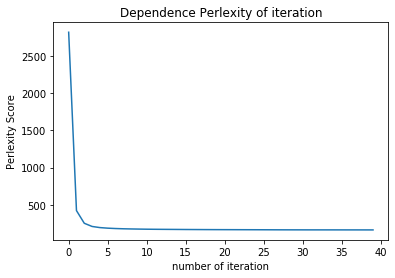

In [377]:
perplexity_plot_ngram(classification_model)

In [378]:
classification_model_topic_model = TopicModel(classification_model)
classification_model_topic_model.describe_scores()

last_value
model_id                   score_name                                 
--20h36m04s_13d06m2020y--- PerlexityScore_ngram                161.604
                           PerlexityScore_info                 43.0405
                           SparsityPhiScore_ngram             0.882816
                           SparsityPhiScore_info              0.161652
                           SparsityThetaScore                 0.203403
                           TopTokensScore.average_coherence          0
                           TopTokensScore.num_tokens               150
                           BackgroundTokensRatioScore         0.256156

In [379]:
TopTokensViewer(model=classification_model_topic_model,
               class_ids=['@ngram', '@info']).view_from_jupyter()

topic_0 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 9.846750 
 
 
 &ТИП_ЦЕЛИ_другое 
 6.370850 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.597660 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.383260 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.003470 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.424130 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 3.146570 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.115970 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.750250 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.608130 
 
 topic_0 modality token 
 
 @ngram 
 работа 
 8.444140 
 
 
 хороший 
 5.646570 
 
 
 стать 
 4.123120 
 
 
 специалист 
 3.576300 
 
 
 стать_хороший 
 2.475660 
 
 
 рынок 
 2.314030 
 
 
 найти 
 2.071840 
 
 
 вуз 
 1.910560 
 
 
 иностранный 
 1.796610 
 
 
 труд 
 1.668970

topic_1 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.199360 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.922200 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 5.089890 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 3.894760 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.844830 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.837610 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.388580 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.064530 
 
 
 &ТИП_ЦЕЛИ_Включиться_в_новый_проект/деятельность 
 3.051070 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 2.448690 
 
 topic_1 modality token 
 
 @ngram 
 стать 
 8.095620 
 
 
 область 
 5.242880 
 
 
 свой 
 3.322550 
 
 
 управление 
 2.919610 
 
 
 проект 
 2.718960 
 
 
 профессионал 
 1.915360 
 
 
 создать 
 1.790560 
 
 
 специалист 
 1.754200 
 
 
 наука 
 1.373610 
 
 
 проектный 
 1.291320

topic_2 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.849800 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.106950 
 
 
 &ТИП_ЦЕЛИ_другое 
 5.456310 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.484060 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.468180 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.445110 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.251210 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.246620 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.012110 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.879990 
 
 topic_2 modality token 
 
 @ngram 
 развитие 
 10.145720 
 
 
 рост 
 6.740770 
 
 
 карьерный 
 3.699420 
 
 
 время 
 3.045700 
 
 
 карьерный_рост 
 2.808690 
 
 
 весь 
 2.020070 
 
 
 личный 
 1.957540 
 
 
 эффективность 
 1.886790 
 
 
 жизнь 
 1.863080 
 
 
 тренд 
 1.745380

topic_3 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.754250 
 
 
 &ТИП_ЦЕЛИ_другое 
 6.056520 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.584990 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.370980 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.326400 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.967950 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.345590 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.299840 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 3.117250 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.962330 
 
 topic_3 modality token 
 
 @ngram 
 курс 
 4.976580 
 
 
 изучить 
 4.858890 
 
 
 технология 
 4.771020 
 
 
 современный 
 3.565940 
 
 
 профессия 
 2.144930 
 
 
 развить 
 1.950910 
 
 
 управлять 
 1.579420 
 
 
 научный 
 1.579060 
 
 
 программа 
 1.288400 
 
 
 психология 
 1.203750

topic_4 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 11.454370 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.909370 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.210380 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.861910 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.350160 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.196560 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.171850 
 
 
 &ТИП_ЦЕЛИ_другое 
 2.857140 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 2.751330 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_есть_границы 
 2.545400 
 
 topic_4 modality token 
 
 @ngram 
 научиться 
 10.158940 
 
 
 получить 
 4.243170 
 
 
 диплом 
 3.860650 
 
 
 освоить 
 2.504280 
 
 
 получить_диплом 
 2.474510 
 
 
 улучшить 
 2.289070 
 
 
 освоение 
 2.196420 
 
 
 дать 
 2.142140 
 
 
 навык 
 1.902160 
 
 
 читать 
 1.733880

topic_5 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 9.747520 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 6.528840 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 4.285030 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 4.002170 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.947680 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.327880 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.068610 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 3.058000 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 2.860860 
 
 
 &ТИП_ЦЕЛИ_другое 
 2.727990 
 
 topic_5 modality token 
 
 @ngram 
 новый 
 12.990030 
 
 
 знание 
 11.043980 
 
 
 навык 
 9.072280 
 
 
 получение 
 9.064660 
 
 
 новый_знание 
 3.895730 
 
 
 получение_новый 
 3.895730 
 
 
 приобретение 
 3.496130 
 
 
 умение 
 3.496130 
 
 
 знание_навык 
 2.471170 
 
 
 знание_умение 
 2.244000

topic_6 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.536280 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.569330 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.736940 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.610470 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.523480 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.453860 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.365060 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.136610 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.813200 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 2.624060 
 
 topic_6 modality token 
 
 @ngram 
 новое 
 13.744940 
 
 
 узнать 
 3.788340 
 
 
 изучение 
 2.315980 
 
 
 узнать_новое 
 2.285720 
 
 
 интересный 
 1.877770 
 
 
 самореализация 
 1.267970 
 
 
 свой 
 1.249950 
 
 
 умный 
 1.065440 
 
 
 постоянный 
 1.054200 
 
 
 понимание 
 1.020970

topic_7 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 6.798370 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.315980 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.157490 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.281330 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.236080 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.102440 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.049550 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.759320 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 2.740590 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 2.651350 
 
 topic_7 modality token 
 
 @ngram 
 который 
 4.493780 
 
 
 саморазвитие 
 3.086620 
 
 
 цель 
 3.086620 
 
 
 хотеть 
 2.831540 
 
 
 расширить 
 2.004700 
 
 
 достижение 
 1.687750 
 
 
 область 
 1.609860 
 
 
 развиваться 
 1.434730 
 
 
 работать 
 1.294920 
 
 
 самосовершенствование 
 1.182270

topic_8 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 12.331280 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 8.598920 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.144590 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.086670 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.428430 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.193940 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.157310 
 
 
 &ТИП_ЦЕЛИ_Получить_официальное_образование_(с_дипломом) 
 2.952030 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_есть_границы 
 2.814880 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Учусь_в_вузе_(очная_форма_обучения) 
 2.085400 
 
 topic_8 modality token 
 
 @ngram 
 образование 
 9.538490 
 
 
 получить 
 7.529550 
 
 
 сфера 
 6.592700 
 
 
 обучение 
 5.989540 
 
 
 высокий 
 4.525620 
 
 
 бизнес 
 2.893980 
 
 
 высокий_образование 
 2.812640 
 
 
 получить_высокий 
 2.406370 
 
 
 профессиональный_сфера 
 1.273690 
 
 
 получить_образование 
 1.193150

topic_9 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 9.634960 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.748580 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.310280 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.142150 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.689440 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.454430 
 
 
 &ОБЛАСТЬ_ЦЕЛИ_Универсальные_компетенции,_гибкие_навыки_(soft_skills) 
 3.066320 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 2.770910 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.708840 
 
 
 &РЕЗУЛЬТАТ_Да,_нечетко 
 2.604980 
 
 topic_9 modality token 
 
 @ngram 
 компетенция 
 13.101920 
 
 
 навык 
 4.852350 
 
 
 профессиональный 
 4.634000 
 
 
 развитие 
 3.809770 
 
 
 свой 
 2.462420 
 
 
 цифровой 
 2.255630 
 
 
 профессиональный_компетенция 
 1.970450 
 
 
 профессиональный_навык 
 1.685770 
 
 
 книга 
 1.472630 
 
 
 качество 
 1.461390

topic_10 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 10.034170 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.205770 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 4.661980 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.280590 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.905890 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_есть_границы 
 3.569420 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.288800 
 
 
 &ТИП_ЦЕЛИ_Получить_официальное_образование_(с_дипломом) 
 2.925050 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 2.826330 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.354740 
 
 topic_10 modality token 
 
 @ngram 
 закончить 
 5.668800 
 
 
 университет 
 2.954350 
 
 
 диссертация 
 2.889170 
 
 
 учёба 
 2.415320 
 
 
 окончить 
 2.100040 
 
 
 защитить 
 1.942600 
 
 
 закончить_университет 
 1.785330 
 
 
 профессиональный_рост 
 1.778720 
 
 
 докторский 
 1.706760 
 
 
 докторский_диссертация 
 1.549740

topic_11 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 10.431650 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 6.527960 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 4.927350 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.721780 
 
 
 &ПОДОБЛАСТЬ_ЦЕЛИ_Иностранные_языки 
 4.543180 
 
 
 &ОБЛАСТЬ_ЦЕЛИ_Иностранные_языки,_гуманитарные_знания_и_навыки 
 4.403250 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.962380 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.480740 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.445750 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.227750 
 
 topic_11 modality token 
 
 @ngram 
 язык 
 12.080620 
 
 
 английский 
 8.186220 
 
 
 английский_язык 
 5.406940 
 
 
 выучить 
 5.261060 
 
 
 программирование 
 3.505970 
 
 
 уровень 
 2.374690 
 
 
 выучить_английский 
 1.994910 
 
 
 язык_программирование 
 1.706740 
 
 
 изучение 
 1.667240 
 
 
 повышение_квалификация 
 1.634780

topic_12 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 11.050660 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 7.169730 
 
 
 &ТИП_ЦЕЛИ_другое 
 4.354080 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 4.196100 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 4.066090 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.842900 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.560410 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.126590 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.981260 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 2.952290 
 
 topic_12 modality token 
 
 @ngram 
 повышение 
 12.911000 
 
 
 уровень 
 10.710400 
 
 
 профессиональный 
 10.594490 
 
 
 повысить 
 5.530320 
 
 
 повышение_уровень 
 2.891880 
 
 
 квалификация 
 2.295470 
 
 
 повышение_профессиональный 
 2.116890 
 
 
 профессиональный_уровень 
 1.997930 
 
 
 свой 
 1.989320 
 
 
 уровень_знание 
 1.700890

topic_13 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 7.177650 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 4.513140 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.787010 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.622820 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 3.247500 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 3.177210 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.150710 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 3.043360 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 2.708790 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.386860 
 
 topic_13 modality token 
 
 @ngram 
 большой 
 3.301040 
 
 
 деятельность 
 3.143570 
 
 
 мир 
 2.009810 
 
 
 познание 
 1.963880 
 
 
 знать 
 1.963830 
 
 
 личностный 
 1.788440 
 
 
 задача 
 1.670710 
 
 
 собственный 
 1.644150 
 
 
 решение 
 1.379930 
 
 
 свой 
 1.206300

topic_14 modality token 
 
 @info 
 &РЕЗУЛЬТАТ_Да,_четко 
 8.520890 
 
 
 &ПРЕГРАДЫ_Не_вижу_преград 
 5.104340 
 
 
 &ТИП_ЦЕЛИ_другое 
 3.799510 
 
 
 &ТИП_ЦЕЛИ_Получить_знания_в_новой_области 
 3.644080 
 
 
 &ПРЕГРАДЫ_есть_преграды 
 3.495530 
 
 
 &ТИП_ЦЕЛИ_Приобрести_новые_навыки 
 3.151750 
 
 
 &ВРЕМЕННЫЕ_ГРАНИЦЫ_Нет_жестких_сроков 
 2.994990 
 
 
 &ТИП_ЦЕЛИ_Развить_имеющиеся_знания_и_навыки 
 2.974740 
 
 
 &ОСНОВНОЙ_ВИД_ДЕЙТЕЛЬНОСТИ_Работаю_в_организации,_предприятии 
 2.653190 
 
 
 &ПЕРВЫЙ_ШАГ_знаю_с_чего_начать 
 2.554800 
 
 topic_14 modality token 
 
 @ngram 
 знание 
 16.883910 
 
 
 получить 
 5.667080 
 
 
 расширение 
 3.979410 
 
 
 новое_знание 
 3.337890 
 
 
 кругозор 
 2.814100 
 
 
 свой 
 2.555000 
 
 
 получить_новое 
 2.117580 
 
 
 человек 
 1.988280 
 
 
 получить_знание 
 1.654730 
 
 
 самообразование 
 1.618550

In [380]:
TopDocumentsViewer(model=classification_model_topic_model, dataset=data, max_top_number=5).view_from_jupyter()

Topic name: topic_0 70 быть конкурентноспособным на рынке труда. 538 Быть конкурентноспособной на рынке труда. 172 найти хорошую высокооплачиваемую работу. 1741 найти достойную работу. 717 Оставаться востребованным специалистом. Topic name: topic_1 4944 Стать профессионалом в своей области. 998 Стать сильным и грамотным руководителем. 2975 Стать министром регионально/краевого правительства. 2976 Стать министром регионально/краевого правительства. 3256 доктор технических наук. Topic name: topic_2 108 Идти в ногу с развитием общества. 2142 Идти в ногу со временем. 3299 Идти в ногу со временем. 1991 идти в ногу со временем. 1151 шагать в ногу со временем. Topic name: topic_3 349 Уметь управлять отделом. 4739 Изучить курс психологии поведения людей. 5300 Прохождение курсов . 1841 Уметь управлять масштабной сетью в компании. 3763 Развить управлченческие навыкы. Topic name: topic_4 2069 Научиться работать с большими данными. 2870 Научиться играть на гитаре как проффессионал. 2014 Научиться писать красивый код. 4151 Освоить методы математического анализа. 1683 Научиться работать с инструментами (Tableau, D3.js) для визуализации данных. Topic name: topic_5 2547 Приобретение новых знаний, умений и навыков . 594 получение новых навыков. 2676 Получение новых навыков. 898 Приобретение новых навыков. 816 приобретение новых навыков . Topic name: topic_6 232 Понимание процессов изменений во внешней среде.. 556 Познавать новое и интересное. 1614 Сохранение гибкости и свежести разума путем его снабжения разнообразными инструментами. 1076 Извлечь максимальную информацию для себя с каждой темы. 206 Понимание процессов изменений во внешней среде.. Topic name: topic_7 1313 Совершенствоваться в том, что мне нравится и у меня это хорошо получается. Ведь если это мне нравится и само хорошо получается, то если в этом еще и развиваться, то это просто бомба!. 1992 Мне нравится развиваться в разных областях. 32 Достижение желаемых целей. 5861 Достижение моих целей, без саморазвития это невозможно. 2002 Мне нравится развиваться в разных областях. Topic name: topic_8 2435 получить высшее экономическое образование. 626 Получить высшее экономическое образование . 3282 Пройти обучение на трекера в первом полугодии 2020 года. 3284 Пройти обучение на трекера в первом полугодии 2020 года. 4185 Получить высшее образование . Topic name: topic_9 4281 Развитие управленческих компетенций. 3243 Развитие профессиональных навыков и компетенций (Business development). 2477 совершенствовать навык публичных выступлений и преодолеть страх перед аудиторией. 958 развитие управленческих навыков. 3800 развитие управленческих навыков. Topic name: topic_10 2513 Закончить диссертационное исследование и успешно защитить докторскую диссертацию. 3353 Подготовка к защите докторской диссертации. 3730 Подготовка и защита докторской диссертации. 4816 Окончить Аспирантуру и защитить КТН. 2407 написать и защитить докторскую диссертацию. Topic name: topic_11 4082 Свободное владение английским языком. 1317 Свободно владеть английским языком. 3197 свободно владеть английским языком. 1838 Преодалеть языковой барьер для общения на английском языке. 2411 свободно разговаривать на английском языке. Topic name: topic_12 4103 систематическое повышения профессионального уровня. 834 Повышение уровня профессионального мастерства . 308 повышение уровня квалификации. 1810 Повшение уровня компетентности и профессионализма. 441 повышение уровня квалификации. Topic name: topic_13 4545 Чем больше знаю я, тем больше знают мои ученики. 1105 Побороть остаток лени, усилить мотивацию . 821 Сохранять темп познания. Остановиться - значит отстать от прогресса. 4599 Ввести следующий 4 источник, на планете.. 116 Больше знать и уметь. Topic name: topic_14 4086 расширение кругозора, эрудиции. 2713 Расширение и углубление теоретических знаний. 4242 Углубление и расширение теоретических знаний. 1322 Совершенствование, расширение своих знаний. 3345 Расширение теоретических знаний.

Добавим регуляризаторы. Теперь это ARTM, а не PLSA.

In [381]:
classification_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_ngram',
                                                       class_ids=['@ngram'],
                                                       dictionary=dictionary))
classification_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_info',
                                                       class_ids=['@info'],
                                                       dictionary=dictionary))
classification_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer_specificity',
                                                       class_ids=['@specificity'],
                                                       dictionary=dictionary))
classification_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer'))
classification_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer_ngram',
                                                       class_ids=['@ngram']))
classification_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer_info',
                                                       class_ids=['@info']))

In [382]:
classification_model.regularizers['SparsePhiRegularizer_ngram'].tau = -100
classification_model.regularizers['SparsePhiRegularizer_info'].tau = -1
classification_model.regularizers['SparsePhiRegularizer_specificity'].tau = -10
classification_model.regularizers['SparseThetaRegularizer'].tau = -10
classification_model.regularizers['DecorrelatorPhiRegularizer_ngram'].tau = 10000
classification_model.regularizers['DecorrelatorPhiRegularizer_info'].tau = 1

classification_model.fit_offline(batch_vectorizer=train_batch_vectorizer, num_collection_passes=15)

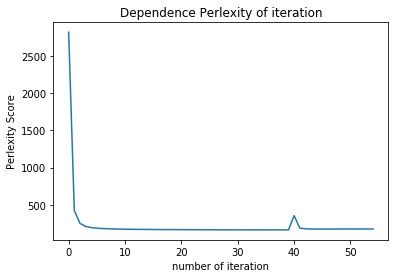

In [383]:
perplexity_plot_ngram(classification_model)

In [384]:
classification_model_topic_model = TopicModel(classification_model)
classification_model_topic_model.describe_scores()

last_value
model_id                   score_name                                 
--20h36m09s_13d06m2020y--- PerlexityScore_ngram                173.817
                           PerlexityScore_info                 41.5337
                           SparsityPhiScore_ngram             0.910006
                           SparsityPhiScore_info              0.227139
                           SparsityThetaScore                 0.902441
                           TopTokensScore.average_coherence          0
                           TopTokensScore.num_tokens               150
                           BackgroundTokensRatioScore                0

In [385]:
batch_vectorizer_test=artm.BatchVectorizer(data_path='vw_documents_test.txt',
                                           data_format='vowpal_wabbit',
                                           batch_size=10000,
                                           target_folder='./test_batches')

dictionary_test = batch_vectorizer_test.dictionary

theta_test = classification_model.transform(batch_vectorizer=batch_vectorizer_test)

p_cd_test = classification_model.transform(batch_vectorizer=batch_vectorizer_test,
                            predict_class_id='@specificity')

y_pred_proba_artm = p_cd_test.loc['1']
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_artm)

dist_min = math.inf
for x, y, treshold in zip(fpr, tpr, thresholds):
    if euclidean([0, 1], [x, y]) < dist_min:
        T_artm = treshold
        dist_min = euclidean([0, 1], [x, y])
        x_artm = x
        y_artm = y

y_pred_labels_artm = []
for document in p_cd_test.columns:
    if p_cd_test[document].loc['1'] >= T_artm:
        y_pred_labels_artm.append(1)
    else:
        y_pred_labels_artm.append(0)
        
p_cd_test.columns = sorted(list(map(lambda item: int(item), p_cd_test.columns)))

roc_auc = roc_auc_score(y_test, y_pred_proba_artm)
precision = precision_score(y_test, y_pred_labels_artm)
recall = recall_score(y_test, y_pred_labels_artm)
accuracy = accuracy_score(y_test, y_pred_labels_artm)

baseline_results['ARTM_classification'] = [roc_auc, precision, recall, accuracy]

In [386]:
baseline_results

,MultinomialNB,LogRegression_CV,ARTM_classification
roc_auc,0.853594,0.853779,0.787452
precision,0.788851,0.792321,0.705634
recall,0.702256,0.682707,0.753383
accuracy,0.782784,0.778077,0.749159


In [387]:
fpr, tpr, thresholds = roc_curve(y_test_count_vect, y_pred_proba_count_vect)
dist_min = math.inf
for x, y, treshold in zip(fpr, tpr, thresholds):
    if euclidean([0, 1], [x, y]) < dist_min:
        T_count_vect = treshold
        dist_min = euclidean([0, 1], [x, y])
        x_count_vect = x
        y_count_vect = y
        
fpr, tpr, thresholds = roc_curve(y_test_count_vect, y_pred_proba_mnb)
dist_min = math.inf
for x, y, treshold in zip(fpr, tpr, thresholds):
    if euclidean([0, 1], [x, y]) < dist_min:
        T_count_vect = treshold
        dist_min = euclidean([0, 1], [x, y])
        x_mnb = x
        y_mnb = y

fpr, tpr, thresholds = roc_curve(y_test_Tfidf, y_pred_proba_Tfidf)
dist_min = math.inf
for x, y, treshold in zip(fpr, tpr, thresholds):
    if euclidean([0, 1], [x, y]) < dist_min:
        T_Tfidf = treshold
        dist_min = euclidean([0, 1], [x, y])
        x_Tfidf = x
        y_Tfidf = y

[-0.1, 1.1, -0.1, 1.1]

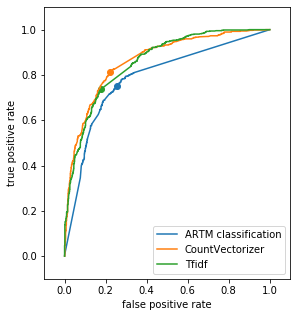

In [96]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
aucs = ""
for x, y, actual, predicted, descr in zip([x_artm, x_count_vect, x_Tfidf],
                                    [y_artm, y_count_vect, y_Tfidf],
                                    [y_test, y_test_count_vect, y_test_Tfidf],
                                    [y_pred_proba_artm, y_pred_proba_count_vect, y_pred_proba_Tfidf],
                                    ['ARTM classification', 'CountVectorizer', 'Tfidf']):
    fpr, tpr, thr = roc_curve(actual, predicted)
    plt.plot(fpr, tpr, label=descr)
    plt.scatter(x, y)
    aucs += descr + ":%3f"%roc_auc_score(actual, predicted) + " "
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.axis([-0.1, 1.1, -0.1, 1.1])

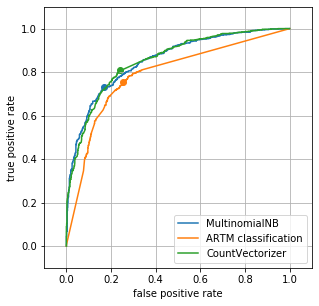

In [391]:
fig, ax = plt.subplots(figsize=[4.8, 4.8])
for x, y, actual, predicted, descr in zip([x_mnb, x_artm, x_count_vect],
                                    [y_mnb, y_artm, y_count_vect],
                                    [y_test_count_vect, y_test, y_test_count_vect],
                                    [y_pred_proba_mnb, y_pred_proba_artm, y_pred_proba_count_vect],
                                    ['MultinomialNB', 'ARTM classification', 'CountVectorizer']):
    fpr, tpr, thr = roc_curve(actual, predicted)
    ax.plot(fpr, tpr, label=descr)
    ax.scatter(x, y)
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.legend(loc=4)
ax.grid(axis = 'both')
ax.axis([-0.1, 1.1, -0.1, 1.1])
fig.savefig('./images/baseline ROC кривая.pdf')
fig.savefig('./images/baseline ROC кривая.png')